In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pygmt
from obspy.core import UTCDateTime

In [2]:
# Read in features, look at names & datatypes
df_original = pd.read_csv('P_station_analysis/p_features.csv', dtype={'location_code': str})
print(len(df_original))
print(df_original.dtypes)

72952
arrival_identifier                int64
avg_noise_1.00                  float64
avg_noise_10.00                 float64
avg_noise_11.00                 float64
avg_noise_12.00                 float64
avg_noise_13.00                 float64
avg_noise_14.00                 float64
avg_noise_15.00                 float64
avg_noise_16.00                 float64
avg_noise_17.00                 float64
avg_noise_18.00                 float64
avg_noise_2.00                  float64
avg_noise_3.00                  float64
avg_noise_4.00                  float64
avg_noise_5.00                  float64
avg_noise_6.00                  float64
avg_noise_7.00                  float64
avg_noise_8.00                  float64
avg_noise_9.00                  float64
avg_signal_1.00                 float64
avg_signal_10.00                float64
avg_signal_11.00                float64
avg_signal_12.00                float64
avg_signal_13.00                float64
avg_signal_14.00                fl

In [3]:
# This catalog of events seems to be missing 2 events 60055267, 60071327
# ngb_event_df = pd.read_csv("NGB_events_201309_201407.csv")
# ngb_event_df

# df_ngb_old = df_original[np.isin(df_original.event_identifier, ngb_event_df.evid)]

In [4]:
# Get metadata for 1 and 3c stations
eq_meta_onec = pd.read_csv("currentEarthquakeArrivalInformation1CWithGains.csv")
eq_meta_threec = pd.read_csv("currentEarthquakeArrivalInformation3CWithGains.csv")
eq_meta_all = pd.concat([eq_meta_onec, eq_meta_threec])

# Reduce to just location information
all_eq_locs = eq_meta_all.drop_duplicates("evid")[["evid", "event_lat", "event_lon", "origin_time"]]
all_eq_locs.columns = ["event_identifier", "event_lat", "event_lon", "origin_time"]

# Reduce to events in the dataset 
eq_locs_df = all_eq_locs[np.isin(all_eq_locs.event_identifier, df_original.event_identifier.unique())]
# Make date column for filtering
eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))

/tmp/ipykernel_4824/2636885443.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  eq_meta_threec = pd.read_csv("currentEarthquakeArrivalInformation3CWithGains.csv")
/tmp/ipykernel_4824/2636885443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))


In [5]:
# Set filter bounds
lat_min = 44.680
lat_max = 44.870
lon_max = 110.850
lon_min = 110.640
date_min = 130901  # YYMMDD
date_max = 140630  # YYMMDD
bounds = {"lat_min": lat_min,
          "lat_max": lat_max,
          "lon_max": lon_max,
          "lon_min": lon_min,
          "date_min": date_min,
          "date_max": date_max}

# Get ngb event ids
ngb_event_locs = eq_locs_df.loc[
        (eq_locs_df["date"] >= bounds["date_min"]) & (eq_locs_df["date"] <= bounds["date_max"]) & (eq_locs_df["event_lat"] >= bounds["lat_min"])
        & (eq_locs_df["event_lat"] <= bounds["lat_max"]) & (-1 * eq_locs_df["event_lon"] >= bounds["lon_min"]) & (
                    -1 * eq_locs_df["event_lon"] <= bounds["lon_max"])]

In [6]:
df_ngb_removed = df_original[~np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
df_ngb = df_original[np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
np.where(np.isin(df_ngb_removed.event_identifier, df_ngb.event_identifier))

(array([], dtype=int64),)

In [7]:
# Read in park and caldera boundaries
utahnet_path = "../maps/utahnet"
ys_border = pd.read_csv(f"{utahnet_path}/yell.border.g", delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(f"{utahnet_path}/caldera.ys", sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1

In [8]:
# Lat/lon bounding box I could use to scale the source locations
bb_lat_min = ys_border.Latitude.min() - 0.2
bb_lat_max = ys_border.Latitude.max()
bb_lon_min = ys_border.Longitude.min() - 0.15
bb_lon_max = ys_border.Longitude.max()
ys_bb = [[bb_lon_max, bb_lat_max], [bb_lon_max, bb_lat_min], [bb_lon_min, bb_lat_min], [bb_lon_min, bb_lat_max], [bb_lon_max, bb_lat_max]]

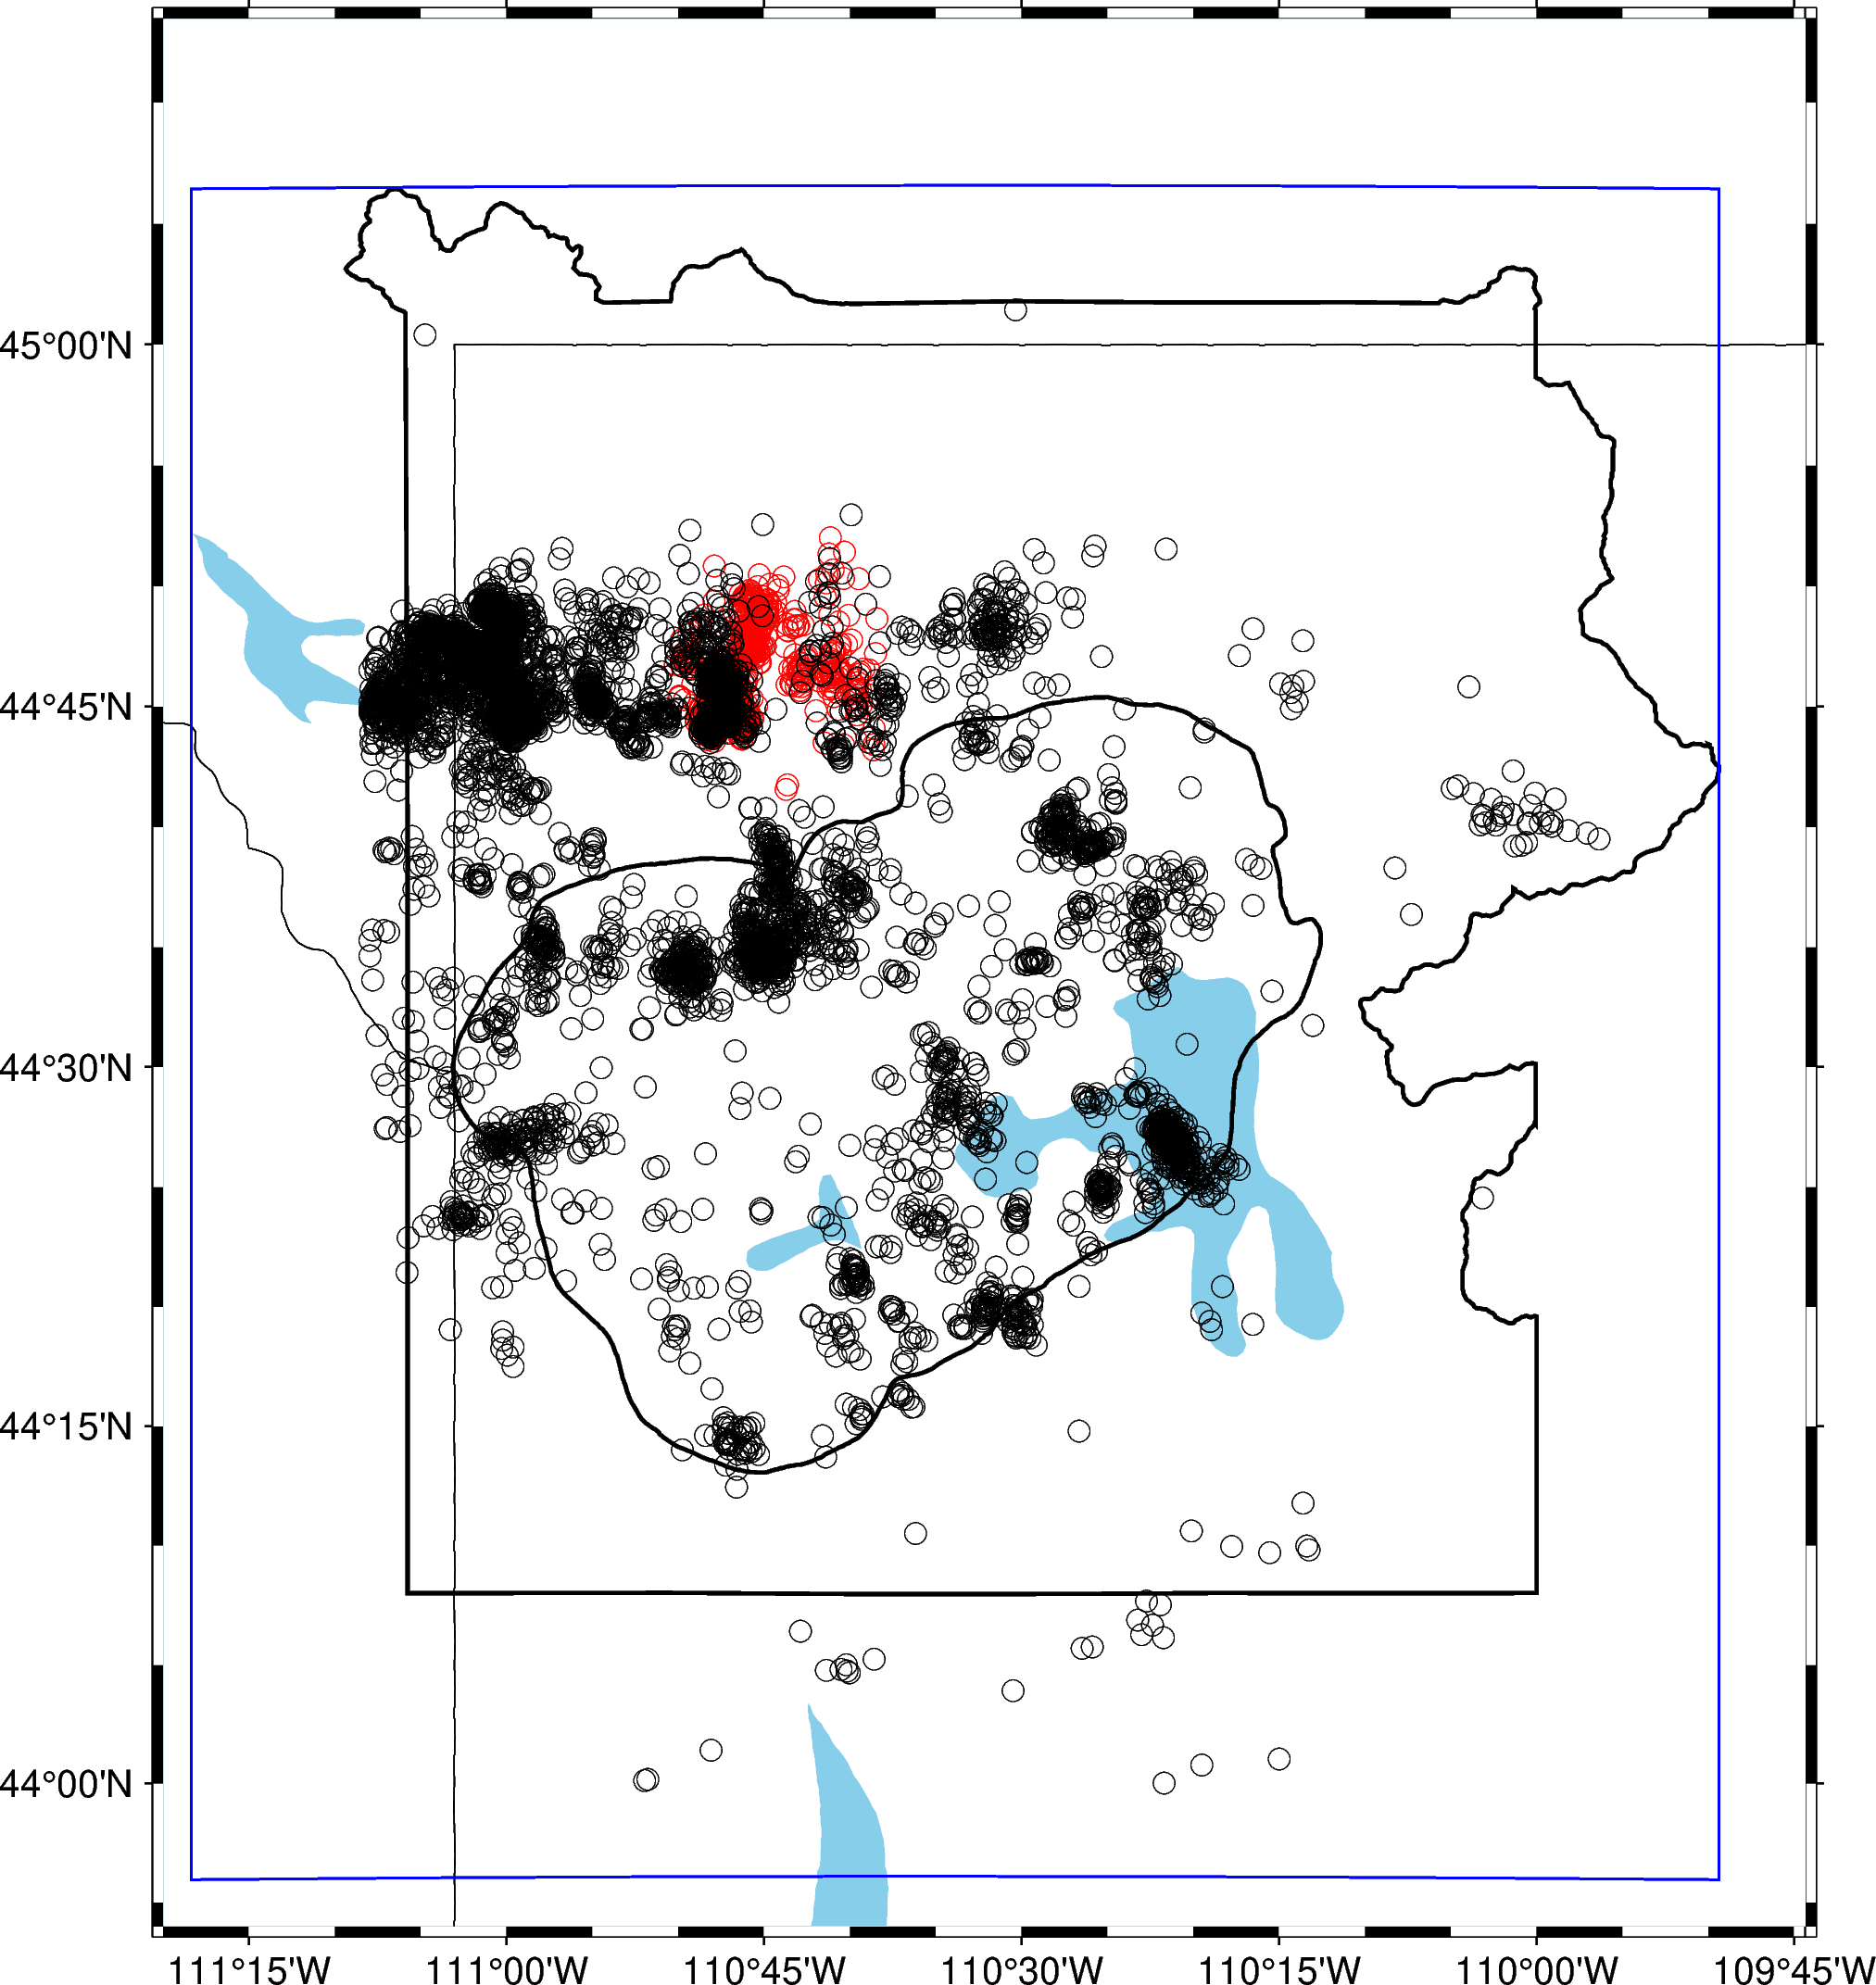

In [9]:
#Draw event map 
region = [
    eq_locs_df.event_lon.min() - 0.2,
    eq_locs_df.event_lon.max() + 0.2,
    eq_locs_df.event_lat.min() - 0.1,
    eq_locs_df.event_lat.max() + 0.2,
]

unique_locations = df_ngb_removed[["source_longitude", "source_latitude"]].drop_duplicates()
unique_ngb_locations = df_ngb[["source_longitude", "source_latitude"]].drop_duplicates()

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(land="white", borders=2, water="skyblue")
fig.plot(data=ys_border, pen="1.0p,black")
fig.plot(data=caldera, pen='1.0p,black')
fig.plot(x=unique_ngb_locations.source_longitude, y=unique_ngb_locations.source_latitude, style="c0.2c", pen="0.2p,red")
fig.plot(x=unique_locations.source_longitude, y=unique_locations.source_latitude, style="c0.2c", pen="0.2p,black")
fig.plot(ys_bb, pen="0.6p,blue")
fig.show()

In [10]:
# Keep stations with more than 350 observations (all togethre, including NGB)
stat_counts = df_original.value_counts("station").to_frame().reset_index()
stat_counts.columns = ["Station", "Count"]
df_org_filtcounts = df_ngb_removed[np.isin(df_ngb_removed.station, stat_counts[stat_counts.Count >= 350])]

## Feature selection?

In [11]:
# Computes the feature matrix from a dataframe
def compute_feature_df(df, scaler = True):
    # Loosely speaking empirical magnitudes look like:
    # M = log10(A) + Q(Delta) 
    # where A is the amplitude and Q a distance dependent correction term.
    # Additionally, the difference between log10 and log amounts to a scalar
    # that a machine can learn.
    # Basically, I'm interested in features that:
    #   (1) Measure size in, potentially, different amplitudes.
    # different `passbands' deviates from the noise, 
    n_rows = len(df)
    n_columns = 47
    X = np.zeros([n_rows, n_columns])
    # Get a proxy on size
    
    # These are effectively amplitude ratios.  Note,
    # log(a/b) = log(a) - log(b)
    X[:,0]  = np.log(df['avg_signal_1.00']) - np.log(df['avg_noise_1.00'])
    X[:,1]  = np.log(df['avg_signal_2.00']) - np.log(df['avg_noise_2.00'])
    X[:,2]  = np.log(df['avg_signal_3.00']) - np.log(df['avg_noise_3.00'])
    X[:,3]  = np.log(df['avg_signal_4.00']) - np.log(df['avg_noise_4.00'])
    X[:,4]  = np.log(df['avg_signal_5.00']) - np.log(df['avg_noise_5.00'])
    X[:,5]  = np.log(df['avg_signal_6.00']) - np.log(df['avg_noise_6.00'])
    X[:,6]  = np.log(df['avg_signal_7.00']) - np.log(df['avg_noise_7.00'])
    X[:,7]  = np.log(df['avg_signal_8.00']) - np.log(df['avg_noise_8.00'])
    X[:,8]  = np.log(df['avg_signal_9.00']) - np.log(df['avg_noise_9.00'])
    X[:,9]  = np.log(df['avg_signal_10.00']) - np.log(df['avg_noise_10.00'])
    X[:,10] = np.log(df['avg_signal_11.00']) - np.log(df['avg_noise_11.00'])
    X[:,11] = np.log(df['avg_signal_12.00']) - np.log(df['avg_noise_12.00'])
    X[:,12] = np.log(df['avg_signal_13.00']) - np.log(df['avg_noise_13.00'])
    X[:,13] = np.log(df['avg_signal_14.00']) - np.log(df['avg_noise_14.00'])
    X[:,14] = np.log(df['avg_signal_15.00']) - np.log(df['avg_noise_15.00'])
    X[:,15] = np.log(df['avg_signal_16.00']) - np.log(df['avg_noise_16.00'])
    X[:,16] = np.log(df['avg_signal_17.00']) - np.log(df['avg_noise_17.00'])
    X[:,17] = np.log(df['avg_signal_18.00']) - np.log(df['avg_noise_18.00'])
    # Look at amplitudes
    X[:,18] = np.log(df['avg_signal_1.00']) 
    X[:,19] = np.log(df['avg_signal_2.00']) 
    X[:,20] = np.log(df['avg_signal_3.00']) 
    X[:,21] = np.log(df['avg_signal_4.00']) 
    X[:,22] = np.log(df['avg_signal_5.00'])
    X[:,23] = np.log(df['avg_signal_6.00'])
    X[:,24] = np.log(df['avg_signal_7.00'])
    X[:,25] = np.log(df['avg_signal_8.00'])
    X[:,26] = np.log(df['avg_signal_9.00'])
    X[:,27] = np.log(df['avg_signal_10.00'])
    X[:,28] = np.log(df['avg_signal_11.00'])
    X[:,29] = np.log(df['avg_signal_12.00'])
    X[:,30] = np.log(df['avg_signal_13.00'])
    X[:,31] = np.log(df['avg_signal_14.00'])
    X[:,32] = np.log(df['avg_signal_15.00'])
    X[:,33] = np.log(df['avg_signal_16.00'])
    X[:,34] = np.log(df['avg_signal_17.00'])
    X[:,35] = np.log(df['avg_signal_18.00'])
    # Frequency and max amplitude
    X[:,36] = np.log(df['signal_dominant_frequency'])
    X[:,37] = np.log(df['signal_dominant_amplitude'])
    # Time-based featuers: Look at max amplitudes of noise/signal
    X[:,38] = np.log(df['noise_maximum_value']  - df['noise_minimum_value'])
    X[:,39] = np.log(df['signal_maximum_value'] - df['signal_minimum_value'])
    X[:,40] = np.log(df['signal_variance'])
    X[:,41] = np.log(df['noise_variance'])
    # Source/recv distance (take log to flatten this)
    X[:,42] = np.log(df['source_receiver_distance_km'])
    X[:,43] = df['source_depth_km']
    # Single stations can learn location
    X[:,44] = df['source_latitude']
    X[:,45] = df['source_longitude']
    # X[:,46] = np.sin(df['source_receiver_back_azimuth'])
    X[:,46] = df['source_receiver_back_azimuth']

    
    # Standardize features
    if (scaler):
        scaler = StandardScaler()
        scaler = scaler.fit(X)
        X = scaler.transform(X)
        return X, scaler
    
    return X
    
#X, scaler = compute_feature_matrix(df)

In [12]:
# Make cross validation splits across evids
from sklearn.model_selection import KFold

def make_cv_folds(train_df):
    evids = train_df.event_identifier.unique()
    kf = KFold(n_splits=5, shuffle=True, random_state=843824)
    folds = []
    for train_index, test_index in kf.split(evids):
        # Get the evids corresponding to the split indicies
        fold_train_evids = evids[train_index]
        fold_test_evids = evids[test_index]
        # Get rows of training dataset that correspond to split evids
        fold_train_inds = np.where(np.isin(train_df.event_identifier, fold_train_evids))[0]
        fold_test_inds = np.where(np.isin(train_df.event_identifier, fold_test_evids))[0]

        folds.append((fold_train_inds, fold_test_inds))
        
    return folds

In [100]:
def svr_cv(X, y, folds, C=0.5, epsilon=0.1):
    print(C, epsilon)
    svr = SVR(C=C, epsilon=epsilon)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    cv_scores = cross_validate(pipeline, X, y, scoring="r2", cv=folds)["test_score"]
    
    return cv_scores

In [14]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import r2_score

In [15]:
test_size = 0.2
# master evid seperation
evids = np.unique(df_org_filtcounts.event_identifier)
train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

In [16]:
n_stats = (stat_counts.Count > 350).sum()
first_stat = 0

stat_results_18_dep_b208 = {}
for station in stat_counts.iloc[first_stat:n_stats].Station.values:
    print("Working on station:", station)

    station_df = df_org_filtcounts[df_org_filtcounts.station == station]

#     evids = np.unique(station_df.event_identifier)
#     train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

    train_inds = np.isin(station_df.event_identifier, train_evids)
    train_df = station_df[train_inds]
    test_df = station_df[~train_inds]
    
    print(f"{len(train_df)} training examples - {(len(train_df)/len(station_df))*100}%")
    print(f"{len(test_df)} testing examples - {(len(test_df)/len(station_df))*100}%")

    folds = make_cv_folds(train_df)

    train_feat_matrix_unscaled = compute_feature_df(train_df, scaler=False)
    train_y = train_df.magnitude.values

    train_feat_df_unscaled = pd.DataFrame(train_feat_matrix_unscaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                     "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                     "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                     "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                     "amp_ratio_17.0", "amp_ratio_18.0", 
                                     "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                     "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                     "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                     "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                     "amp_17.0", "amp_18.0",
                                     "signal_dominant_frequency", "signal_dominant_amplitude", 
                                     "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                     "source_receiver_distance_logkm", "source_depth_km","source_latitude", 
                                     "source_longitude", "receiver_back_azimuth"])

#     fewer_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth",'amp_ratio_01.0', "amp_18.0",
#                               "amp_01.0", "signal_variance", "source_depth_km", "noise_variance"]

#     fewer_features_lat_lon = ['source_longitude', "source_latitude",'amp_ratio_01.0', "amp_01.0", "amp_18.0", 
#                               "signal_variance", "source_depth_km", "noise_variance"]

    fewer_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth", "amp_18.0",
                              "amp_02.0", "amp_01.0", "signal_variance", "source_depth_km"]

    fewer_features_lat_lon = ['source_longitude', "source_latitude", "amp_02.0", "amp_18.0", "amp_01.0", 
                              "signal_variance", "source_depth_km"]
    
    print("SVR with all features:")
    X = train_feat_df_unscaled
    print("Input shape", X.shape)
    all_feat_cv = svr_cv(X, train_y, folds)
    print(all_feat_cv)
    print(np.mean(all_feat_cv))

    print("SVR with 5 features, including lat and lon:")
    X = train_feat_df_unscaled[fewer_features_lat_lon]
    print("Input shape", X.shape)
    fewer_feat_lat_lon_cv = svr_cv(X, train_y, folds)
    print(fewer_feat_lat_lon_cv)
    print(np.mean(fewer_feat_lat_lon_cv))

    print("SVR with 5 features, including sr-distance and back azimuth:")
    X = train_feat_df_unscaled[fewer_features_sr]
    print("Input shape", X.shape)
    fewer_feat_sr_cv = svr_cv(X, train_y, folds)
    print(fewer_feat_sr_cv)
    print(np.mean(fewer_feat_sr_cv))
    
    stat_results_18_dep_b208[f"{station}"] = {"all":np.mean(all_feat_cv), "ll":np.mean(fewer_feat_lat_lon_cv),
                                 "sr":np.mean(fewer_feat_sr_cv)}

Working on station: YNR
3621 training examples - 80.37735849056604%
884 testing examples - 19.622641509433965%
SVR with all features:
Input shape (3621, 47)
0.3 0.1
[0.85859741 0.86875752 0.84793349 0.85251049 0.85546226]
0.8566522338064335
SVR with 5 features, including lat and lon:
Input shape (3621, 7)
0.3 0.1
[0.84994236 0.85990319 0.85254504 0.83638752 0.86230514]
0.8522166486766798
SVR with 5 features, including sr-distance and back azimuth:
Input shape (3621, 7)
0.3 0.1
[0.8538965  0.86389897 0.84997515 0.83345154 0.86053078]
0.8523505866814685
Working on station: YHH
3496 training examples - 80.34934497816593%
855 testing examples - 19.65065502183406%
SVR with all features:
Input shape (3496, 47)
0.3 0.1
[0.86337712 0.87812224 0.86003886 0.85473045 0.86390391]
0.8640345161611366
SVR with 5 features, including lat and lon:
Input shape (3496, 7)
0.3 0.1


KeyboardInterrupt: 

In [17]:
from collections import OrderedDict

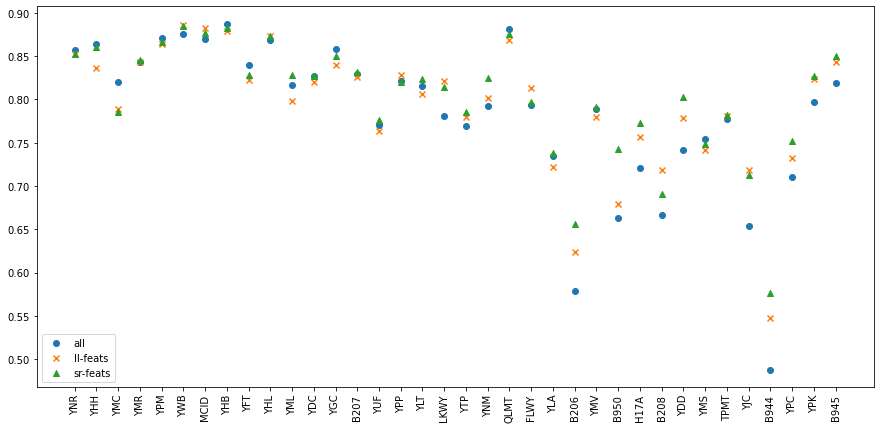

In [17]:
fig = plt.figure(figsize=(15, 7))

x_range = range(first_stat, n_stats)
for ind in x_range:
    stat = stat_counts.iloc[ind].Station
    plt.scatter(ind, stat_results_18_dep_b208[stat]["all"], label="all", marker="o", color="C0")
    plt.scatter(ind, stat_results_18_dep_b208[stat]["ll"], label="ll-feats", marker="x", color="C1")
    plt.scatter(ind, stat_results_18_dep_b208[stat]["sr"], label="sr-feats", marker="^", color="C2")
    
plt.xticks(x_range, labels=stat_counts.iloc[first_stat:n_stats].Station.values, rotation="vertical");

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left")

In [101]:
n_stats = (stat_counts.Count > 350).sum()
first_stat = 0


stat_results_amp_compare = {}
for station in stat_counts.iloc[first_stat:n_stats].Station.values:
    print("Working on station:", station)

    station_df = df_org_filtcounts[df_org_filtcounts.station == station]

#     evids = np.unique(station_df.event_identifier)
#     train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

    train_inds = np.isin(station_df.event_identifier, train_evids)
    train_df = station_df[train_inds]
    
    print(f"{len(train_df)} training examples - {(len(train_df)/len(station_df))*100}%")
    
#     assert len(train_df.event_identifier.unique()) == len(train_evids)
#     assert len(test_df.event_identifier.unique()) == len(test_evids)
#    assert len(test_df) + len(train_df) == len(station_df)

    folds = make_cv_folds(train_df)

    train_feat_matrix_unscaled = compute_feature_df(train_df, scaler=False)
    train_y = train_df.magnitude.values

    train_feat_df_unscaled = pd.DataFrame(train_feat_matrix_unscaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                     "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                     "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                     "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                     "amp_ratio_17.0", "amp_ratio_18.0", 
                                     "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                     "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                     "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                     "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                     "amp_17.0", "amp_18.0",
                                     "signal_dominant_frequency", "signal_dominant_amplitude", 
                                     "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                     "source_receiver_distance_logkm", "source_depth_km","source_latitude", 
                                     "source_longitude", "receiver_back_azimuth"])


    amp1_amp2 = ['source_receiver_distance_logkm', "receiver_back_azimuth", "amp_18.0",
                              "amp_02.0", "amp_01.0", "signal_variance", "source_depth_km"]

    amp1 = ['source_receiver_distance_logkm', "receiver_back_azimuth", "amp_18.0",
                              "amp_01.0", "signal_variance", "source_depth_km"]
        
    amp2 = ['source_receiver_distance_logkm', "receiver_back_azimuth", "amp_18.0",
                              "amp_02.0", "signal_variance", "source_depth_km"]
        
    amp1_ampr1 = ['source_receiver_distance_logkm', "receiver_back_azimuth", "amp_18.0",
                              "amp_01.0", "amp_ratio_01.0", "signal_variance", "source_depth_km"]
    
    amp1_ampr1_no18 = ['source_receiver_distance_logkm', "receiver_back_azimuth",
                              "amp_01.0", "amp_ratio_01.0", "signal_variance", "source_depth_km"]
        
    amp1_ampr1_nodep = ['source_receiver_distance_logkm', "receiver_back_azimuth", "amp_18.0",
                              "amp_01.0", "amp_ratio_01.0", "signal_variance"]

    
    print("SVR with all features:")
    X = train_feat_df_unscaled
    print("Input shape", X.shape)
    all_feat_cv = svr_cv(X, train_y, folds)
    print(all_feat_cv)
    print(np.mean(all_feat_cv))
    
    print("SVR with amp1 and amp2:")
    X = train_feat_df_unscaled[amp1_amp2]
    print("Input shape", X.shape)
    amp1_amp2_feat_cv = svr_cv(X, train_y, folds)
    print(amp1_amp2_feat_cv)
    print(np.mean(amp1_amp2_feat_cv))

    print("SVR with just amp 1.0:")
    X = train_feat_df_unscaled[amp1]
    print("Input shape", X.shape)
    amp1_feat_cv = svr_cv(X, train_y, folds)
    print(amp1_feat_cv)
    print(np.mean(amp1_feat_cv))

    print("SVR with amp 1.0 and amp ratio 1.0:")
    X = train_feat_df_unscaled[amp1_ampr1]
    print("Input shape", X.shape)
    amp1_ampr1_feat_cv = svr_cv(X, train_y, folds)
    print(amp1_ampr1_feat_cv)
    print(np.mean(amp1_ampr1_feat_cv))
    
    print("SVR with just amp 2.0:")
    X = train_feat_df_unscaled[amp2]
    print("Input shape", X.shape)
    amp2_feat_cv = svr_cv(X, train_y, folds)
    print(amp2_feat_cv)
    print(np.mean(amp2_feat_cv))
    
    print("SVR with amp 1.0 and amp ratio 1.0 and no depth:")
    X = train_feat_df_unscaled[amp1_ampr1_nodep]
    print("Input shape", X.shape)
    amp1_ampr1_nodep_feat_cv = svr_cv(X, train_y, folds)
    print(amp1_ampr1_nodep_feat_cv)
    print(np.mean(amp1_ampr1_nodep_feat_cv))
    
    print("SVR with amp 1.0 and amp ratio 1.0 and no amp 18.0:")
    X = train_feat_df_unscaled[amp1_ampr1_no18]
    print("Input shape", X.shape)
    amp1_ampr1_no18_feat_cv = svr_cv(X, train_y, folds)
    print(amp1_ampr1_no18_feat_cv)
    print(np.mean(amp1_ampr1_no18_feat_cv))
    
    
    stat_results_amp_compare[f"{station}"] = {"all":np.mean(all_feat_cv), "amp1":np.mean(amp1_feat_cv),
                                 "amp1_ampr1":np.mean(amp1_ampr1_feat_cv), "amp2":np.mean(amp2_feat_cv),
                                              "amp1_amp2":np.mean(amp1_amp2_feat_cv)
                                              ,"amp1_ampr1_nodep":np.mean(amp1_ampr1_nodep_feat_cv)
                                             ,"amp1_ampr1_no18":np.mean(amp1_ampr1_no18_feat_cv)}

Working on station: YNR
3621 training examples - 80.37735849056604%
SVR with all features:
Input shape (3621, 47)
0.5 0.1
[0.86216385 0.87563035 0.85362763 0.85583933 0.86055886]
0.861564001617413
SVR with amp1 and amp2:
Input shape (3621, 7)
0.5 0.1
[0.8555041  0.86678316 0.85354775 0.83674762 0.8638577 ]
0.8552880652874568
SVR with just amp 1.0:
Input shape (3621, 6)
0.5 0.1
[0.85131491 0.86571944 0.84896542 0.82856803 0.86074636]
0.851062832992404
SVR with amp 1.0 and amp ratio 1.0:
Input shape (3621, 7)
0.5 0.1
[0.86124539 0.8653948  0.84126185 0.83722973 0.86087495]
0.8532013451989146
SVR with just amp 2.0:
Input shape (3621, 6)
0.5 0.1
[0.85584651 0.87110341 0.84951921 0.84144207 0.86380256]
0.8563427533768113
SVR with amp 1.0 and amp ratio 1.0 and no depth:
Input shape (3621, 6)
0.5 0.1
[0.85951978 0.86753809 0.84197758 0.83514437 0.86111646]
0.853059257276881
SVR with amp 1.0 and amp ratio 1.0 and no amp 18.0:
Input shape (3621, 6)
0.5 0.1
[0.86055977 0.8628421  0.83989109 0.83

[0.89928894 0.86357494 0.88358356 0.86036376 0.88280221]
0.8779226820642803
Working on station: YFT
2591 training examples - 79.77216748768473%
SVR with all features:
Input shape (2591, 47)
0.5 0.1
[0.85870714 0.83158394 0.83954755 0.86506872 0.84373779]
0.8477290296699185
SVR with amp1 and amp2:
Input shape (2591, 7)
0.5 0.1
[0.84467203 0.81210984 0.83521297 0.85054761 0.82122434]
0.8327533567008908
SVR with just amp 1.0:
Input shape (2591, 6)
0.5 0.1
[0.83758353 0.81614113 0.82913127 0.85033288 0.82494652]
0.8316270650692251
SVR with amp 1.0 and amp ratio 1.0:
Input shape (2591, 7)
0.5 0.1
[0.83352039 0.81433862 0.82634179 0.84968618 0.82349389]
0.8294761728950256
SVR with just amp 2.0:
Input shape (2591, 6)
0.5 0.1
[0.84703311 0.80957564 0.83502344 0.84430542 0.81175768]
0.8295390580788149
SVR with amp 1.0 and amp ratio 1.0 and no depth:
Input shape (2591, 6)
0.5 0.1
[0.83599365 0.81785733 0.82824839 0.84605448 0.82110026]
0.8298508229420166
SVR with amp 1.0 and amp ratio 1.0 and no

[0.83384735 0.83049333 0.81159362 0.78983989 0.81091538]
0.8153379123033592
Working on station: YLT
1235 training examples - 80.45602605863192%
SVR with all features:
Input shape (1235, 47)
0.5 0.1
[0.83743673 0.83373748 0.85464822 0.80033932 0.80452373]
0.8261370950084457
SVR with amp1 and amp2:
Input shape (1235, 7)
0.5 0.1
[0.82808173 0.82662893 0.86173648 0.80756033 0.82348236]
0.8294979651164722
SVR with just amp 1.0:
Input shape (1235, 6)
0.5 0.1
[0.82531232 0.83168976 0.86607306 0.81171649 0.82508556]
0.8319754389480802
SVR with amp 1.0 and amp ratio 1.0:
Input shape (1235, 7)
0.5 0.1
[0.81871706 0.82187487 0.86143208 0.80386453 0.83154271]
0.8274862506786947
SVR with just amp 2.0:
Input shape (1235, 6)
0.5 0.1
[0.8192482  0.82399687 0.85649598 0.80285148 0.80207746]
0.8209339978364885
SVR with amp 1.0 and amp ratio 1.0 and no depth:
Input shape (1235, 6)
0.5 0.1
[0.81715128 0.83081808 0.8631031  0.79489282 0.81728926]
0.8246509071265147
SVR with amp 1.0 and amp ratio 1.0 and no

[0.82959487 0.80717353 0.84402365 0.8089675  0.72608475]
0.8031688592462556
SVR with amp1 and amp2:
Input shape (445, 7)
0.5 0.1
[0.8198323  0.83121053 0.85253826 0.84140328 0.63069598]
0.7951360707707188
SVR with just amp 1.0:
Input shape (445, 6)
0.5 0.1
[0.77102482 0.83076657 0.84145883 0.81316968 0.59979128]
0.7712422338077742
SVR with amp 1.0 and amp ratio 1.0:
Input shape (445, 7)
0.5 0.1
[0.80352547 0.81746934 0.82887822 0.80787166 0.69771361]
0.7910916583600522
SVR with just amp 2.0:
Input shape (445, 6)
0.5 0.1
[0.80975166 0.81941459 0.85582021 0.81972966 0.62684389]
0.7863120002175362
SVR with amp 1.0 and amp ratio 1.0 and no depth:
Input shape (445, 6)
0.5 0.1
[0.8122161  0.81698756 0.82594737 0.80417047 0.69849434]
0.7915631702689101
SVR with amp 1.0 and amp ratio 1.0 and no amp 18.0:
Input shape (445, 6)
0.5 0.1
[0.80019998 0.81789864 0.82349573 0.81211333 0.69418328]
0.7895781920518077
Working on station: B950
306 training examples - 79.48051948051949%
SVR with all featur

[0.65483066 0.54120019 0.61691764 0.62063943 0.27989999]
0.5426975845639348
SVR with amp1 and amp2:
Input shape (334, 7)
0.5 0.1
[0.75754969 0.65769231 0.60195647 0.74014849 0.25770716]
0.6030108271443517
SVR with just amp 1.0:
Input shape (334, 6)
0.5 0.1
[0.77158007 0.66872761 0.58445619 0.74568201 0.26317666]
0.6067245075259099
SVR with amp 1.0 and amp ratio 1.0:
Input shape (334, 7)
0.5 0.1
[0.76472218 0.67764911 0.62368818 0.69927837 0.24899833]
0.6028672316553435
SVR with just amp 2.0:
Input shape (334, 6)
0.5 0.1
[0.73230202 0.61142028 0.58594614 0.72492076 0.23461618]
0.5778410757848053
SVR with amp 1.0 and amp ratio 1.0 and no depth:
Input shape (334, 6)
0.5 0.1
[0.74184152 0.64350865 0.61046677 0.67470724 0.25745157]
0.5855951512525356
SVR with amp 1.0 and amp ratio 1.0 and no amp 18.0:
Input shape (334, 6)
0.5 0.1
[0.77423661 0.67431722 0.64703183 0.70047755 0.23041229]
0.6052951006146289
Working on station: YPC
336 training examples - 80.0%
SVR with all features:
Input shap

In [102]:
amp_compare_df = pd.DataFrame(stat_results_amp_compare).transpose()
amp_compare_df[["amp1", "amp2", "amp1_ampr1", "amp1_amp2", "amp1_ampr1_nodep", "amp1_ampr1_no18"]].idxmax(axis=1)

YNR                 amp2
YHH            amp1_amp2
YMC           amp1_ampr1
YMR            amp1_amp2
YPM                 amp1
YWB            amp1_amp2
MCID                amp1
YHB            amp1_amp2
YFT            amp1_amp2
YHL            amp1_amp2
YML            amp1_amp2
YDC            amp1_amp2
YGC            amp1_amp2
B207                amp1
YUF            amp1_amp2
YPP            amp1_amp2
YLT                 amp1
LKWY           amp1_amp2
YTP            amp1_amp2
YNM            amp1_amp2
QLMT           amp1_amp2
FLWY           amp1_amp2
YLA     amp1_ampr1_nodep
B206                amp1
YMV            amp1_amp2
B950           amp1_amp2
H17A           amp1_amp2
B208    amp1_ampr1_nodep
YDD            amp1_amp2
YMS            amp1_amp2
TPMT           amp1_amp2
YJC      amp1_ampr1_no18
B944                amp1
YPC            amp1_amp2
YPK                 amp1
B945    amp1_ampr1_nodep
dtype: object

In [103]:
amp_compare_df[["amp1", "amp2", "amp1_ampr1", "amp1_amp2", "amp1_ampr1_nodep", "amp1_ampr1_no18"]].idxmax(axis=1).value_counts()

amp1_amp2           23
amp1                 7
amp1_ampr1_nodep     3
amp2                 1
amp1_ampr1           1
amp1_ampr1_no18      1
dtype: int64

In [104]:
amp_compare_df[["amp1", "amp2", "amp1_ampr1", "amp1_ampr1_nodep", "amp1_ampr1_no18"]].idxmax(axis=1)

YNR                 amp2
YHH                 amp2
YMC           amp1_ampr1
YMR                 amp2
YPM                 amp1
YWB                 amp2
MCID                amp1
YHB                 amp2
YFT                 amp1
YHL                 amp2
YML                 amp1
YDC                 amp2
YGC                 amp2
B207                amp1
YUF                 amp2
YPP                 amp2
YLT                 amp1
LKWY                amp2
YTP                 amp1
YNM                 amp2
QLMT                amp1
FLWY                amp1
YLA     amp1_ampr1_nodep
B206                amp1
YMV     amp1_ampr1_nodep
B950                amp1
H17A                amp1
B208    amp1_ampr1_nodep
YDD      amp1_ampr1_no18
YMS      amp1_ampr1_no18
TPMT    amp1_ampr1_nodep
YJC      amp1_ampr1_no18
B944                amp1
YPC                 amp1
YPK                 amp1
B945    amp1_ampr1_nodep
dtype: object

In [105]:
amp_compare_df[["amp1", "amp2", "amp1_ampr1", "amp1_ampr1_nodep", "amp1_ampr1_no18"]].idxmax(axis=1).value_counts()

amp1                15
amp2                12
amp1_ampr1_nodep     5
amp1_ampr1_no18      3
amp1_ampr1           1
dtype: int64

In [106]:
(amp_compare_df["amp1_ampr1"] - amp_compare_df[["amp1", "amp2", "amp1_amp2", "amp1_ampr1_nodep", "amp1_ampr1_no18"]].max(axis=1)).sort_values()

B950   -0.029116
YDD    -0.026072
YPC    -0.023758
B945   -0.022106
B208   -0.021086
YNM    -0.017210
LKWY   -0.015062
YTP    -0.014045
B206   -0.011784
YPK    -0.011559
YDC    -0.011331
YWB    -0.011110
H17A   -0.010628
YHB    -0.010097
FLWY   -0.009026
TPMT   -0.007844
YMS    -0.007739
YPP    -0.006936
QLMT   -0.006649
YMR    -0.005776
YUF    -0.005396
YHH    -0.005153
YLT    -0.004489
YJC    -0.004050
YMV    -0.004044
B944   -0.003857
YGC    -0.003832
YHL    -0.003617
MCID   -0.003529
YFT    -0.003277
YNR    -0.003141
B207   -0.003054
YML    -0.002654
YPM    -0.002271
YLA    -0.000556
YMC     0.004558
dtype: float64

In [107]:
(amp_compare_df["amp1_ampr1"] - amp_compare_df[["amp1", "amp2", "amp1_ampr1_nodep", "amp1_ampr1_no18"]].max(axis=1)).sort_values()

B945   -0.022106
B950   -0.022004
B208   -0.021086
YPC    -0.017586
LKWY   -0.012593
YTP    -0.012476
YNM    -0.012084
B206   -0.011784
YPK    -0.011559
YDC    -0.010962
YWB    -0.009834
YHB    -0.009060
TPMT   -0.007748
YMS    -0.007360
H17A   -0.006759
QLMT   -0.006395
FLWY   -0.006378
YDD    -0.005773
YUF    -0.005086
YMR    -0.004697
YLT    -0.004489
YHH    -0.004229
YJC    -0.004050
B944   -0.003857
MCID   -0.003529
YGC    -0.003450
YNR    -0.003141
YPP    -0.003131
B207   -0.003054
YPM    -0.002271
YFT    -0.002151
YHL    -0.001787
YML    -0.001439
YLA    -0.000556
YMV    -0.000472
YMC     0.004558
dtype: float64

In [108]:
amp_compare_df.std(axis=1).sort_values()

YML     0.002817
YHL     0.003258
YLT     0.003551
YNR     0.003582
MCID    0.003616
YMR     0.003690
QLMT    0.004076
YUF     0.004484
YPP     0.005225
YWB     0.005892
TPMT    0.005987
YHH     0.006592
B207    0.006789
YFT     0.006858
YTP     0.006963
YPM     0.007030
YHB     0.007036
LKWY    0.007900
YNM     0.008047
YLA     0.008186
YPK     0.008454
H17A    0.008688
B208    0.009203
B945    0.009631
YMV     0.009734
FLWY    0.010223
YMS     0.010649
YGC     0.011990
YPC     0.012353
YDD     0.013541
YJC     0.017368
YMC     0.017531
B950    0.020320
YDC     0.022196
B944    0.023267
B206    0.029002
dtype: float64

In [109]:
amp_compare_df[["amp1", "amp2","amp1_amp2", "amp1_ampr1", "amp1_ampr1_nodep", "amp1_ampr1_no18"]].std(axis=1).sort_values()

YFT     0.001828
YNR     0.002027
QLMT    0.002732
YML     0.002809
YHL     0.003262
YJC     0.003597
YPP     0.003835
MCID    0.003843
YLT     0.003869
YMR     0.003998
YUF     0.004581
YHB     0.005004
YPK     0.005008
B207    0.005429
YHH     0.005502
YPM     0.005819
YMS     0.005823
YWB     0.006388
LKWY    0.006484
TPMT    0.006550
YTP     0.007088
YNM     0.007315
H17A    0.007450
YMC     0.008141
B206    0.008193
YMV     0.008459
YLA     0.008691
B208    0.009172
B945    0.009443
FLWY    0.009898
YDD     0.009924
YPC     0.010484
YGC     0.011218
B944    0.012091
B950    0.013639
YDC     0.022839
dtype: float64

In [110]:
amp_compare_df.mean()

all                 0.802452
amp1                0.807338
amp1_ampr1          0.803540
amp2                0.804641
amp1_amp2           0.811672
amp1_ampr1_nodep    0.801394
amp1_ampr1_no18     0.801646
dtype: float64

In [128]:
amp_compare_df[(amp_compare_df["amp1"] - amp_compare_df["amp2"]) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18
MCID,0.876204,0.882228,0.878699,0.871942,0.881840,0.876547,0.879891
B207,0.844903,0.838356,0.835302,0.827380,0.838326,0.826184,0.830206
YLT,0.826137,0.831975,0.827486,0.820934,0.829498,0.824651,0.828172
FLWY,0.805608,0.802386,0.796008,0.779336,0.805034,0.787031,0.787944
YLA,0.753760,0.747674,0.753324,0.731291,0.751306,0.753880,0.753055
YMS,0.777706,0.753286,0.750883,0.743040,0.758621,0.755679,0.758243
B944,0.542698,0.606725,0.602867,0.577841,0.603011,0.585595,0.605295
YPK,0.815796,0.841869,0.830310,0.829504,0.839096,0.835074,0.831820
B945,0.842627,0.858145,0.842855,0.847678,0.863562,0.864961,0.846724


In [127]:
amp_compare_df[(amp_compare_df["amp2"] - amp_compare_df["amp1"]) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18
YNM,0.811523,0.815586,0.817267,0.829352,0.834477,0.823618,0.820128
YMV,0.803169,0.771242,0.791092,0.786312,0.795136,0.791563,0.789578
B208,0.714782,0.703773,0.693630,0.714420,0.706718,0.714717,0.694783


In [113]:
amp_compare_df[(amp_compare_df["amp1"] - amp_compare_df["amp1_ampr1"]) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18
YTP,0.781939,0.795907,0.783432,0.791402,0.797477,0.782762,0.781496
B206,0.609133,0.691358,0.679574,0.690891,0.684891,0.669280,0.683619
B950,0.693522,0.746461,0.724458,0.743262,0.753574,0.728901,0.719403
B208,0.714782,0.703773,0.693630,0.714420,0.706718,0.714717,0.694783
YPC,0.730473,0.759426,0.741840,0.754288,0.765598,0.738507,0.747158
YPK,0.815796,0.841869,0.830310,0.829504,0.839096,0.835074,0.831820
B945,0.842627,0.858145,0.842855,0.847678,0.863562,0.864961,0.846724


In [114]:
amp_compare_df[(amp_compare_df["amp1_ampr1"] - amp_compare_df["amp1"] > 0.1)]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18


In [115]:
amp_compare_df[(amp_compare_df["amp2"] - amp_compare_df["amp1_ampr1"]) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18
YDC,0.840070,0.827992,0.824340,0.835303,0.835672,0.821421,0.774794
LKWY,0.807033,0.821648,0.813476,0.826070,0.828538,0.822745,0.812769
YNM,0.811523,0.815586,0.817267,0.829352,0.834477,0.823618,0.820128
B206,0.609133,0.691358,0.679574,0.690891,0.684891,0.669280,0.683619
B950,0.693522,0.746461,0.724458,0.743262,0.753574,0.728901,0.719403
B208,0.714782,0.703773,0.693630,0.714420,0.706718,0.714717,0.694783
YPC,0.730473,0.759426,0.741840,0.754288,0.765598,0.738507,0.747158


In [116]:
amp_compare_df[(amp_compare_df["amp1_amp2"] - amp_compare_df["amp1_ampr1"]) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18
YWB,0.882184,0.879766,0.877143,0.886977,0.888253,0.872850,0.874717
YHB,0.895048,0.879389,0.877609,0.886669,0.887706,0.876042,0.877923
YDC,0.840070,0.827992,0.824340,0.835303,0.835672,0.821421,0.774794
LKWY,0.807033,0.821648,0.813476,0.826070,0.828538,0.822745,0.812769
YTP,0.781939,0.795907,0.783432,0.791402,0.797477,0.782762,0.781496
YNM,0.811523,0.815586,0.817267,0.829352,0.834477,0.823618,0.820128
B950,0.693522,0.746461,0.724458,0.743262,0.753574,0.728901,0.719403
H17A,0.765172,0.785380,0.778620,0.776478,0.789248,0.767752,0.779387
B208,0.714782,0.703773,0.693630,0.714420,0.706718,0.714717,0.694783
YDD,0.770680,0.795111,0.790650,0.795532,0.816721,0.789405,0.796423


In [117]:
amp_compare_df[(amp_compare_df["amp1_ampr1_nodep"] - amp_compare_df["amp1_ampr1"]) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18
B208,0.714782,0.703773,0.693630,0.714420,0.706718,0.714717,0.694783
B945,0.842627,0.858145,0.842855,0.847678,0.863562,0.864961,0.846724


In [118]:
amp_compare_df[(amp_compare_df["amp1_ampr1_no18"] - amp_compare_df["amp1_ampr1"]) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18


In [120]:
amp_compare_df[(amp_compare_df["amp1_ampr1"] - amp_compare_df["amp1_ampr1_no18"]) > 0.04]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18
YDC,0.84007,0.827992,0.82434,0.835303,0.835672,0.821421,0.774794


In [122]:
amp_compare_df[(amp_compare_df["amp1_ampr1"] - 
                amp_compare_df[["amp1", "amp2","amp1_amp2", "amp1_ampr1_nodep", "amp1_ampr1_no18"]].max(axis=1)) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18


In [123]:
amp_compare_df[(amp_compare_df["amp1_ampr1"] - amp_compare_df[["amp1", "amp2"]].max(axis=1)) > 0.1]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18


In [129]:
amp_compare_df[(amp_compare_df[["amp1", "amp2", "amp1_ampr1", "amp1_ampr1_nodep", 
                                "amp1_ampr1_no18"]].max(axis=1) - amp_compare_df["amp1_ampr1"]) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18
YDC,0.840070,0.827992,0.824340,0.835303,0.835672,0.821421,0.774794
LKWY,0.807033,0.821648,0.813476,0.826070,0.828538,0.822745,0.812769
YTP,0.781939,0.795907,0.783432,0.791402,0.797477,0.782762,0.781496
YNM,0.811523,0.815586,0.817267,0.829352,0.834477,0.823618,0.820128
B206,0.609133,0.691358,0.679574,0.690891,0.684891,0.669280,0.683619
B950,0.693522,0.746461,0.724458,0.743262,0.753574,0.728901,0.719403
B208,0.714782,0.703773,0.693630,0.714420,0.706718,0.714717,0.694783
YPC,0.730473,0.759426,0.741840,0.754288,0.765598,0.738507,0.747158
YPK,0.815796,0.841869,0.830310,0.829504,0.839096,0.835074,0.831820
B945,0.842627,0.858145,0.842855,0.847678,0.863562,0.864961,0.846724


In [130]:
amp_compare_df[(amp_compare_df["amp1_amp2"] - 
                amp_compare_df[["amp1", "amp2", 
                                "amp1_ampr1", "amp1_ampr1_nodep", "amp1_ampr1_no18"]].max(axis=1)) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18
YDD,0.77068,0.795111,0.79065,0.795532,0.816721,0.789405,0.796423


In [131]:
amp_compare_df[(amp_compare_df["amp1_ampr1_nodep"] - 
                amp_compare_df[["amp1", "amp2", "amp1_ampr1", "amp1_ampr1_no18"]].max(axis=1)) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18


In [132]:
amp_compare_df[(amp_compare_df["amp1_ampr1_no18"] - 
                amp_compare_df[["amp1", "amp2", "amp1_ampr1", "amp1_ampr1_no18"]].max(axis=1)) > 0.01]

,all,amp1,amp1_ampr1,amp2,amp1_amp2,amp1_ampr1_nodep,amp1_ampr1_no18


In [27]:
n_stats = (stat_counts.Count > 350).sum()
first_stat = 0

stat_results = {}
means = []

stat_results = {}
for station in stat_counts.iloc[first_stat:n_stats].Station.values:
    print("Working on station:", station)

    station_df = df_org_filtcounts[df_org_filtcounts.station == station]

#     evids = np.unique(station_df.event_identifier)
#     train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

    train_inds = np.isin(station_df.event_identifier, train_evids)
    train_df = station_df[train_inds]
    
    print(f"{len(train_df)} training examples - {(len(train_df)/len(station_df))*100}%")

    folds = make_cv_folds(train_df)

    train_feat_matrix_unscaled = compute_feature_df(train_df, scaler=False)
    train_y = train_df.magnitude.values

    train_feat_df_unscaled = pd.DataFrame(train_feat_matrix_unscaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                     "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                     "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                     "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                     "amp_ratio_17.0", "amp_ratio_18.0", 
                                     "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                     "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                     "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                     "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                     "amp_17.0", "amp_18.0",
                                     "signal_dominant_frequency", "signal_dominant_amplitude", 
                                     "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                     "source_receiver_distance_logkm", "source_depth_km","source_latitude", 
                                     "source_longitude", "receiver_back_azimuth"])

    fewer_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth",'amp_ratio_01.0', "amp_18.0",
                              "amp_01.0", "signal_variance", "source_depth_km"]
    
    print("SVR with all features:")
    X = train_feat_df_unscaled
    print("Input shape", X.shape)
    all_feat_cv = svr_cv(X, train_y, folds)
    print(all_feat_cv)
    print(np.mean(all_feat_cv))

    print("SVR with 7 features, including sr-distance and back azimuth:")
    X = train_feat_df_unscaled[fewer_features_sr]
    print("Input shape", X.shape)
    fewer_feat_sr_cv = svr_cv(X, train_y, folds)
    print(fewer_feat_sr_cv)
    print(np.mean(fewer_feat_sr_cv))
    
    if station == "YMC":
        fewer_features_sr.append("noise_variance")
        print("Adding in noise_variance for YMC:")
        X = train_feat_df_unscaled[fewer_features_sr]
        print("Input shape", X.shape)
        fewer_feat_sr_nv_cv = svr_cv(X, train_y, folds)
        print(fewer_feat_sr_nv_cv)
        print(np.mean(fewer_feat_sr_nv_cv))
        
        stat_results[f"{station}"] = {"all":np.mean(all_feat_cv),"mean":np.mean(fewer_feat_sr_cv), 
                                  "min":np.min(fewer_feat_sr_cv), "max":np.max(fewer_feat_sr_cv), 
                                  "mean_nv":np.mean(fewer_feat_sr_nv_cv), 
                                  "min_nv":np.min(fewer_feat_sr_nv_cv), "max_nv":np.max(fewer_feat_sr_nv_cv)}
        means.append(np.mean(fewer_feat_sr_nv_cv))
    
    else:
        stat_results[f"{station}"] = {"all":np.mean(all_feat_cv),"mean":np.mean(fewer_feat_sr_cv), 
                                  "min":np.min(fewer_feat_sr_cv), "max":np.max(fewer_feat_sr_cv)}
        
        means.append(np.mean(all_feat_cv))

Working on station: YNR
3621 training examples - 80.37735849056604%
SVR with all features:
Input shape (3621, 47)
[0.85859741 0.86875752 0.84793349 0.85251049 0.85546226]
0.8566522338064335
SVR with 7 features, including sr-distance and back azimuth:
Input shape (3621, 7)
[0.8591358  0.86103371 0.83757992 0.83286594 0.85661086]
0.8494452465261763
Working on station: YHH
3496 training examples - 80.34934497816593%
SVR with all features:
Input shape (3496, 47)
[0.86337712 0.87812224 0.86003886 0.85473045 0.86390391]
0.8640345161611366
SVR with 7 features, including sr-distance and back azimuth:
Input shape (3496, 7)
[0.85101327 0.86673257 0.83710453 0.85650706 0.85900951]
0.8540733887090368
Working on station: YMC
3209 training examples - 80.38577154308616%
SVR with all features:
Input shape (3209, 47)
[0.81511653 0.82811085 0.81820314 0.80004836 0.83778124]
0.8198520261514102
SVR with 7 features, including sr-distance and back azimuth:
Input shape (3209, 7)
[0.78385591 0.78549376 0.7884

[0.58001524 0.63341227 0.50600616 0.62287237 0.54974172]
0.5784095539988426
SVR with 7 features, including sr-distance and back azimuth:
Input shape (385, 7)
[0.63683958 0.67122285 0.5597046  0.72110358 0.67169382]
0.6521128866749295
Working on station: YMV
445 training examples - 80.03597122302159%
SVR with all features:
Input shape (445, 47)
[0.81438573 0.79371029 0.83590388 0.79707438 0.70495319]
0.7892054971325193
SVR with 7 features, including sr-distance and back azimuth:
Input shape (445, 7)
[0.79052086 0.80974767 0.81222957 0.80847148 0.68998009]
0.7821899324748136
Working on station: B950
306 training examples - 79.48051948051949%
SVR with all features:
Input shape (306, 47)
[0.69979195 0.70492083 0.60606366 0.66993123 0.6333081 ]
0.662803153146179
SVR with 7 features, including sr-distance and back azimuth:
Input shape (306, 7)
[0.71922741 0.74238297 0.7583827  0.69897083 0.66739221]
0.7172712257855179
Working on station: H17A
444 training examples - 78.86323268206039%
SVR wi

0.7844958773382249 0.8336791960577548


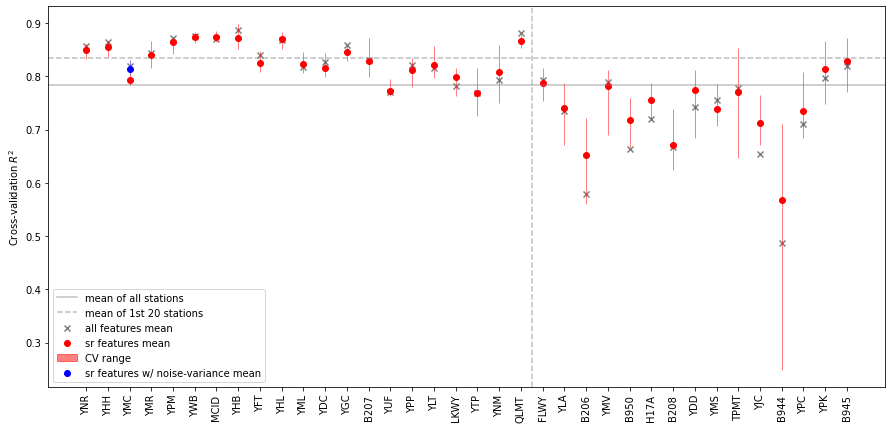

In [28]:
fig = plt.figure(figsize=(15, 7))

x_range = range(first_stat, n_stats)

plt.axhline(np.mean(means), color="gray", alpha=0.5, label="mean of all stations")
plt.axhline(np.mean(means[:20]), color="gray", linestyle="--", alpha=0.5, label="mean of 1st 20 stations")
plt.axvline(20.5, color="gray", linestyle="--", alpha=0.5)

for ind in x_range:
    stat = stat_counts.iloc[ind].Station
    plt.scatter(ind, stat_results[stat]["all"], label="all features mean", marker="x", color="gray")
    plt.scatter(ind, stat_results[stat]["mean"], label="sr features mean", marker="o", color="red")
    plt.fill_between([ind], stat_results[stat]["min"], stat_results[stat]["max"], color="red", alpha=0.5, label="CV range")
    if stat == "YMC":
        plt.scatter(ind, stat_results[stat]["mean_nv"], label="sr features w/ noise-variance mean", marker="o", color="blue")
        plt.fill_between([ind], stat_results[stat]["min_nv"], stat_results[stat]["max_nv"], color="blue", alpha=0.5)
plt.xticks(x_range, labels=stat_counts.iloc[first_stat:n_stats].Station.values, rotation="vertical");

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left")
plt.ylabel(r"Cross-validation $R^2$")
print(np.mean(means), np.mean(means[:20]))

In [29]:
n_stats = (stat_counts.Count > 350).sum()
first_stat = 0

stat_results_nv = {}
for station in stat_counts.iloc[first_stat:n_stats].Station.values:
    print("Working on station:", station)

    station_df = df_org_filtcounts[df_org_filtcounts.station == station]

#     evids = np.unique(station_df.event_identifier)
#     train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

    train_inds = np.isin(station_df.event_identifier, train_evids)
    train_df = station_df[train_inds]
    
    print(f"{len(train_df)} training examples - {(len(train_df)/len(station_df))*100}%")

    folds = make_cv_folds(train_df)

    train_feat_matrix_unscaled = compute_feature_df(train_df, scaler=False)
    train_y = train_df.magnitude.values

    train_feat_df_unscaled = pd.DataFrame(train_feat_matrix_unscaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                     "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                     "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                     "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                     "amp_ratio_17.0", "amp_ratio_18.0", 
                                     "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                     "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                     "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                     "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                     "amp_17.0", "amp_18.0",
                                     "signal_dominant_frequency", "signal_dominant_amplitude", 
                                     "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                     "source_receiver_distance_logkm", "source_depth_km","source_latitude", 
                                     "source_longitude", "receiver_back_azimuth"])

    fewer_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth",'amp_ratio_01.0', "amp_18.0",
                              "amp_01.0", "signal_variance", "source_depth_km"]
    
    print("SVR with all features:")
    X = train_feat_df_unscaled
    print("Input shape", X.shape)
    all_feat_cv = svr_cv(X, train_y, folds)
    print(all_feat_cv)
    print(np.mean(all_feat_cv))

    print("SVR with 7 features, including sr-distance and back azimuth:")
    X = train_feat_df_unscaled[fewer_features_sr]
    print("Input shape", X.shape)
    fewer_feat_sr_cv = svr_cv(X, train_y, folds)
    print(fewer_feat_sr_cv)
    print(np.mean(fewer_feat_sr_cv))
    
    fewer_features_sr.append("noise_variance")
    print("Adding in noise_variance:")
    X = train_feat_df_unscaled[fewer_features_sr]
    print("Input shape", X.shape)
    fewer_feat_sr_nv_cv = svr_cv(X, train_y, folds)
    print(fewer_feat_sr_nv_cv)
    print(np.mean(fewer_feat_sr_nv_cv))
        
    stat_results_nv[f"{station}"] = {"all":np.mean(all_feat_cv),"mean":np.mean(fewer_feat_sr_cv), 
                                  "min":np.min(fewer_feat_sr_cv), "max":np.max(fewer_feat_sr_cv), 
                                  "mean_nv":np.mean(fewer_feat_sr_nv_cv), 
                                  "min_nv":np.min(fewer_feat_sr_nv_cv), "max_nv":np.max(fewer_feat_sr_nv_cv)}
    


Working on station: YNR
3621 training examples - 80.37735849056604%
SVR with all features:
Input shape (3621, 47)
[0.85859741 0.86875752 0.84793349 0.85251049 0.85546226]
0.8566522338064335
SVR with 7 features, including sr-distance and back azimuth:
Input shape (3621, 7)
[0.8591358  0.86103371 0.83757992 0.83286594 0.85661086]
0.8494452465261763
Adding in noise_variance:
Input shape (3621, 8)
[0.86035457 0.8421455  0.83119297 0.83599726 0.84545717]
0.8430294935380755
Working on station: YHH
3496 training examples - 80.34934497816593%
SVR with all features:
Input shape (3496, 47)
[0.86337712 0.87812224 0.86003886 0.85473045 0.86390391]
0.8640345161611366
SVR with 7 features, including sr-distance and back azimuth:
Input shape (3496, 7)
[0.85101327 0.86673257 0.83710453 0.85650706 0.85900951]
0.8540733887090368
Adding in noise_variance:
Input shape (3496, 8)
[0.84593165 0.85113214 0.83565351 0.85609202 0.85200967]
0.8481637991135047
Working on station: YMC
3209 training examples - 80.38

[0.79528949 0.80631764 0.76358018 0.81600077 0.81624223]
0.7994860604854288
Adding in noise_variance:
Input shape (923, 8)
[0.78401846 0.79211746 0.75289139 0.80354392 0.81353506]
0.7892212606593226
Working on station: YTP
862 training examples - 79.52029520295203%
SVR with all features:
Input shape (862, 47)
[0.72032708 0.8026977  0.75627165 0.77051612 0.79560996]
0.7690845004584588
SVR with 7 features, including sr-distance and back azimuth:
Input shape (862, 7)
[0.72452362 0.81490214 0.7604513  0.76371518 0.78361353]
0.7694411535811497
Adding in noise_variance:
Input shape (862, 8)
[0.70800647 0.81040196 0.74039243 0.74585546 0.7819872 ]
0.7573287043030705
Working on station: YNM
408 training examples - 79.2233009708738%
SVR with all features:
Input shape (408, 47)
[0.74575782 0.81679739 0.80155582 0.75420911 0.8440322 ]
0.7924704657904412
SVR with 7 features, including sr-distance and back azimuth:
Input shape (408, 7)
[0.75042965 0.78705474 0.83079223 0.80916991 0.85953715]
0.8073

[0.77047885 0.81113337 0.84850202 0.87244666 0.8415392 ]
0.8288200197705249
Adding in noise_variance:
Input shape (239, 8)
[0.77405741 0.80954553 0.83711795 0.86579365 0.79537748]
0.816378405458785


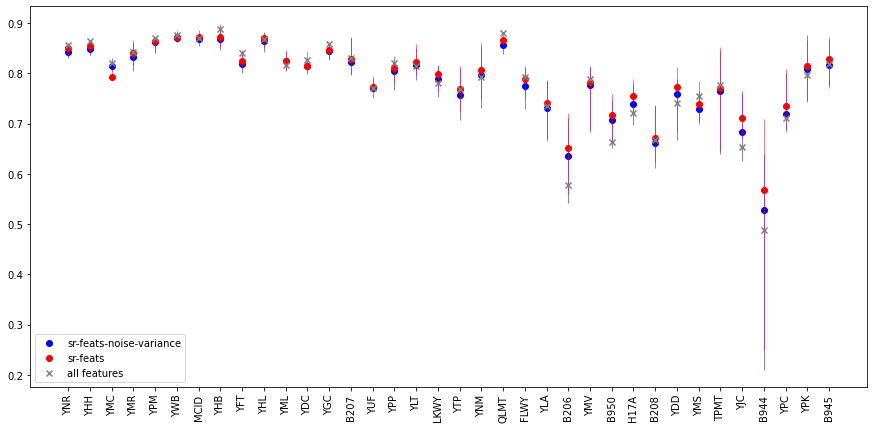

In [30]:
fig = plt.figure(figsize=(15, 7))

x_range = range(first_stat, n_stats)
for ind in x_range:
    stat = stat_counts.iloc[ind].Station
    
    plt.scatter(ind, stat_results_nv[stat]["mean_nv"], label="sr-feats-noise-variance", marker="o", color="blue")
    plt.fill_between([ind], stat_results_nv[stat]["min_nv"], stat_results_nv[stat]["max_nv"], color="blue", alpha=0.5)
    
    plt.scatter(ind, stat_results_nv[stat]["mean"], label="sr-feats", marker="o", color="red")
    plt.fill_between([ind], stat_results_nv[stat]["min"], stat_results_nv[stat]["max"], color="red", alpha=0.5)

    plt.scatter(ind, stat_results_nv[stat]["all"], label="all features", marker="x", color="gray")

        
plt.xticks(x_range, labels=stat_counts.iloc[first_stat:n_stats].Station.values, rotation="vertical");
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left")

# Look at effect of increasing L2 regularization

In [17]:
n_stats = (stat_counts.Count > 350).sum()
first_stat = 0

stat_results = {}
means = []

stat_results = {}
for C in [0.3, 0.5, 0.75, 1.0]:
    for station in stat_counts.iloc[first_stat:n_stats].Station.values:
        print("Working on station:", station)

        station_df = df_org_filtcounts[df_org_filtcounts.station == station]

    #     evids = np.unique(station_df.event_identifier)
    #     train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

        train_inds = np.isin(station_df.event_identifier, train_evids)
        train_df = station_df[train_inds]

        print(f"{len(train_df)} training examples - {(len(train_df)/len(station_df))*100}%")

        folds = make_cv_folds(train_df)

        train_feat_matrix_unscaled = compute_feature_df(train_df, scaler=False)
        train_y = train_df.magnitude.values

        train_feat_df_unscaled = pd.DataFrame(train_feat_matrix_unscaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                         "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                         "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                         "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                         "amp_ratio_17.0", "amp_ratio_18.0", 
                                         "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                         "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                         "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                         "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                         "amp_17.0", "amp_18.0",
                                         "signal_dominant_frequency", "signal_dominant_amplitude", 
                                         "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                         "source_receiver_distance_logkm", "source_depth_km","source_latitude", 
                                         "source_longitude", "receiver_back_azimuth"])

        fewer_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth",'amp_ratio_01.0', "amp_18.0",
                                  "amp_01.0", "signal_variance", "source_depth_km"]

        print("SVR with all features:")
        X = train_feat_df_unscaled
        print("Input shape", X.shape)
        all_feat_cv = svr_cv(X, train_y, folds, C=C)
        print(all_feat_cv)
        print(np.mean(all_feat_cv))

        print("SVR with 7 features, including sr-distance and back azimuth:")
        X = train_feat_df_unscaled[fewer_features_sr]
        print("Input shape", X.shape)
        fewer_feat_sr_cv = svr_cv(X, train_y, folds, C=C)
        print(fewer_feat_sr_cv)
        print(np.mean(fewer_feat_sr_cv))


        stat_results[f"{station}_{C}"] = {"all":np.mean(all_feat_cv),"mean":np.mean(fewer_feat_sr_cv), 
                                      "min":np.min(fewer_feat_sr_cv), "max":np.max(fewer_feat_sr_cv)}

        means.append(np.mean(all_feat_cv))

Working on station: YNR
3621 training examples - 80.37735849056604%
SVR with all features:
Input shape (3621, 47)
0.3 0.1
[0.85859741 0.86875752 0.84793349 0.85251049 0.85546226]
0.8566522338064335
SVR with 7 features, including sr-distance and back azimuth:
Input shape (3621, 7)
0.3 0.1
[0.8591358  0.86103371 0.83757992 0.83286594 0.85661086]
0.8494452465261763
Working on station: YHH
3496 training examples - 80.34934497816593%
SVR with all features:
Input shape (3496, 47)
0.3 0.1
[0.86337712 0.87812224 0.86003886 0.85473045 0.86390391]
0.8640345161611366
SVR with 7 features, including sr-distance and back azimuth:
Input shape (3496, 7)
0.3 0.1
[0.85101327 0.86673257 0.83710453 0.85650706 0.85900951]
0.8540733887090368
Working on station: YMC
3209 training examples - 80.38577154308616%
SVR with all features:
Input shape (3209, 47)
0.3 0.1
[0.81511653 0.82811085 0.81820314 0.80004836 0.83778124]
0.8198520261514102
SVR with 7 features, including sr-distance and back azimuth:
Input shape

[0.58001524 0.63341227 0.50600616 0.62287237 0.54974172]
0.5784095539988426
SVR with 7 features, including sr-distance and back azimuth:
Input shape (385, 7)
0.3 0.1
[0.63683958 0.67122285 0.5597046  0.72110358 0.67169382]
0.6521128866749295
Working on station: YMV
445 training examples - 80.03597122302159%
SVR with all features:
Input shape (445, 47)
0.3 0.1
[0.81438573 0.79371029 0.83590388 0.79707438 0.70495319]
0.7892054971325193
SVR with 7 features, including sr-distance and back azimuth:
Input shape (445, 7)
0.3 0.1
[0.79052086 0.80974767 0.81222957 0.80847148 0.68998009]
0.7821899324748136
Working on station: B950
306 training examples - 79.48051948051949%
SVR with all features:
Input shape (306, 47)
0.3 0.1
[0.69979195 0.70492083 0.60606366 0.66993123 0.6333081 ]
0.662803153146179
SVR with 7 features, including sr-distance and back azimuth:
Input shape (306, 7)
0.3 0.1
[0.71922741 0.74238297 0.7583827  0.69897083 0.66739221]
0.7172712257855179
Working on station: H17A
444 train

[0.82067751 0.82859082 0.81072192 0.83664925 0.84423802]
0.8281755058033825
SVR with 7 features, including sr-distance and back azimuth:
Input shape (2440, 7)
0.5 0.1
[0.81753573 0.83732399 0.8114241  0.84067702 0.85272839]
0.8319378450993143
Working on station: YDC
2258 training examples - 80.38447846208615%
SVR with all features:
Input shape (2258, 47)
0.5 0.1
[0.84993479 0.85286793 0.82323132 0.8346771  0.83963685]
0.8400695967827383
SVR with 7 features, including sr-distance and back azimuth:
Input shape (2258, 7)
0.5 0.1
[0.85212414 0.83755963 0.81151955 0.80985996 0.81063918]
0.8243404937997554
Working on station: YGC
1700 training examples - 80.4162724692526%
SVR with all features:
Input shape (1700, 47)
0.5 0.1
[0.85772663 0.86176929 0.88736112 0.85618366 0.88685039]
0.8699782174085333
SVR with 7 features, including sr-distance and back azimuth:
Input shape (1700, 7)
0.5 0.1
[0.86106243 0.86038417 0.85351522 0.84307378 0.86566397]
0.8567399125028704
Working on station: B207
122

[0.81835294 0.78657972 0.87511049 0.8413083  0.89178374]
0.8426270394720248
SVR with 7 features, including sr-distance and back azimuth:
Input shape (239, 7)
0.5 0.1
[0.77543471 0.82179215 0.85904877 0.87950635 0.87849296]
0.8428549891222717
Working on station: YNR
3621 training examples - 80.37735849056604%
SVR with all features:
Input shape (3621, 47)
0.75 0.1
[0.86506955 0.87965952 0.8558423  0.85844558 0.86317574]
0.8644385393008953
SVR with 7 features, including sr-distance and back azimuth:
Input shape (3621, 7)
0.75 0.1
[0.86191093 0.86728239 0.8417653  0.8378669  0.86292103]
0.8543493108984533
Working on station: YHH
3496 training examples - 80.34934497816593%
SVR with all features:
Input shape (3496, 47)
0.75 0.1
[0.87335561 0.89070446 0.86980856 0.86328558 0.87206658]
0.8738441582773417
SVR with 7 features, including sr-distance and back azimuth:
Input shape (3496, 7)
0.75 0.1
[0.85903904 0.88048179 0.84792735 0.86345215 0.86647411]
0.8634748892878659
Working on station: YMC


[0.76898817 0.75454293 0.69576743 0.78159531 0.79169878]
0.7585185255017054
Working on station: B206
385 training examples - 79.05544147843942%
SVR with all features:
Input shape (385, 47)
0.75 0.1
[0.62017612 0.68726062 0.53077037 0.66984687 0.61238609]
0.6240880155358882
SVR with 7 features, including sr-distance and back azimuth:
Input shape (385, 7)
0.75 0.1
[0.69623407 0.72138454 0.61282095 0.72968153 0.72141566]
0.6963073518647851
Working on station: YMV
445 training examples - 80.03597122302159%
SVR with all features:
Input shape (445, 47)
0.75 0.1
[0.83662854 0.81509451 0.8491722  0.81686789 0.73294379]
0.8101413878029984
SVR with 7 features, including sr-distance and back azimuth:
Input shape (445, 7)
0.75 0.1
[0.80770314 0.82279816 0.83800158 0.8023544  0.69999371]
0.7941701974405649
Working on station: B950
306 training examples - 79.48051948051949%
SVR with all features:
Input shape (306, 47)
0.75 0.1
[0.73025991 0.73139718 0.64839879 0.72216459 0.70539515]
0.70752312364881

[0.87127694 0.89088744 0.8833176  0.88503201 0.90420601]
0.8869440015917254
SVR with 7 features, including sr-distance and back azimuth:
Input shape (2438, 7)
1.0 0.1
[0.87094201 0.88648917 0.87751522 0.87763535 0.8935493 ]
0.8812262106525462
Working on station: YML
2440 training examples - 80.71452199801521%
SVR with all features:
Input shape (2440, 47)
1.0 0.1
[0.83200228 0.83548164 0.81636641 0.84612525 0.85173741]
0.8363425992824227
SVR with 7 features, including sr-distance and back azimuth:
Input shape (2440, 7)
1.0 0.1
[0.82786504 0.84425786 0.81472721 0.85147095 0.85675334]
0.8390148787557468
Working on station: YDC
2258 training examples - 80.38447846208615%
SVR with all features:
Input shape (2258, 47)
1.0 0.1
[0.86119097 0.86336893 0.83444677 0.84882222 0.85164108]
0.8518939959558443
SVR with 7 features, including sr-distance and back azimuth:
Input shape (2258, 7)
1.0 0.1
[0.85689348 0.84290357 0.81800117 0.81523193 0.81826079]
0.8302581887151158
Working on station: YGC
170

[0.71890101 0.61495176 0.67641037 0.68229794 0.30553783]
0.5996197807076501
SVR with 7 features, including sr-distance and back azimuth:
Input shape (334, 7)
1.0 0.1
[0.82070586 0.7102001  0.62212222 0.76539837 0.21762516]
0.6272103427968412
Working on station: YPC
336 training examples - 80.0%
SVR with all features:
Input shape (336, 47)
1.0 0.1
[0.7475698  0.67790261 0.81867045 0.69242258 0.74027651]
0.7353683911547522
SVR with 7 features, including sr-distance and back azimuth:
Input shape (336, 7)
1.0 0.1
[0.77936665 0.71650494 0.81145629 0.69678678 0.71638121]
0.7440991729295423
Working on station: YPK
282 training examples - 82.21574344023324%
SVR with all features:
Input shape (282, 47)
1.0 0.1
[0.77636044 0.85663024 0.871087   0.78554272 0.82084083]
0.8220922478280857
SVR with 7 features, including sr-distance and back azimuth:
Input shape (282, 7)
1.0 0.1
[0.81655677 0.86987868 0.89043748 0.80374912 0.84225159]
0.8445747304219662
Working on station: B945
239 training examples 

In [ ]:
C_stat_results = pd.DataFrame(stat_results)

0.8033990489871942 0.8339629758849199


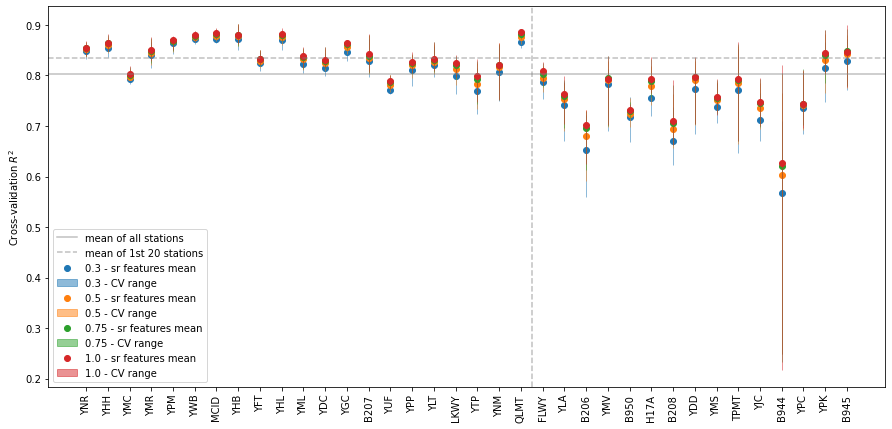

In [23]:
fig = plt.figure(figsize=(15, 7))

x_range = range(first_stat, n_stats)

plt.axhline(np.mean(means), color="gray", alpha=0.5, label="mean of all stations")
plt.axhline(np.mean(means[:20]), color="gray", linestyle="--", alpha=0.5, label="mean of 1st 20 stations")
plt.axvline(20.5, color="gray", linestyle="--", alpha=0.5)

colors = {0.3:"C0", 0.5:"C1", 0.75:"C2", 1.0:"C3"}
for C in [0.3, 0.5, 0.75, 1.0]:
    for ind in x_range:
        stat = stat_counts.iloc[ind].Station
        dict_key = f"{stat}_{C}"
        #plt.scatter(ind, stat_results[dict_key]["all"], label=f" {C} - all features mean", marker="x", color=colors[C])
        plt.scatter(ind, stat_results[dict_key]["mean"], label=f"{C} - sr features mean", marker="o", color=colors[C])
        plt.fill_between([ind], stat_results[dict_key]["min"], stat_results[dict_key]["max"], color=colors[C], alpha=0.5, label=f"{C} - CV range")

plt.xticks(x_range, labels=stat_counts.iloc[first_stat:n_stats].Station.values, rotation="vertical");

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left")
plt.ylabel(r"Cross-validation $R^2$")
print(np.mean(means), np.mean(means[:20]))